### Workflow 👇

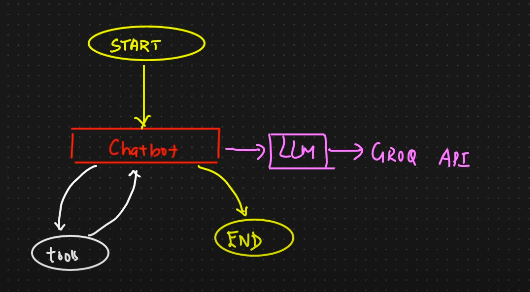

In [20]:
!pip install langgraph langsmith langchain_groq langchain_community arxiv wikipedia

In [1]:
from typing import Annotated # For managing the States
from typing_extensions import TypedDict

In [2]:
# Working with External Tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxiv and Wikipedia Tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper = api_wrapper)

In [3]:
wiki_tool("Who is Sam Altman ?")

/var/folders/mb/n07mq38j10x93x8ln22q2h180000gn/T/ipykernel_50772/1731263934.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  wiki_tool("Who is Sam Altman ?")


'Page: Sam Altman\nSummary: Samuel Harris Gibstine Altman (born April 22, 1985) is an American entrepreneur, investor, and chief executive officer of OpenAI since 2019. He is considered one of the leading figures of the AI boom. \nAltman dropped out of Stanford University after two years and founded Lo'

In [4]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [26]:
tools = [wiki_tool]

<br>
<br>

### LangGraph Application

In [6]:
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
from langgraph.graph import START, END, StateGraph

In [8]:
graph_builder = StateGraph(State)

In [9]:
# Calling the LLM

import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

In [10]:
llm = ChatGroq(groq_api_key = groq_api_key, model_name = "llama-3.1-8b-instant")

In [11]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x109f05970>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10a1351c0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [12]:
llm_with_tools = llm.bind_tools(tools = tools) # Binding LLM to the tools

In [13]:
# Creating ChatBot

def chatBot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition

In [15]:
# Creating the flow of the excution
'''
KEEP RFEERRING THE FLOWCHART MENTIOEND AT THE TOP
'''
graph_builder.add_node("chatbot", chatBot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools = tools)
graph_builder.add_node("tools", tool_node) # Tools added as a NODE

# Connect ToolNode to chatBot
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [16]:
graph = graph_builder.compile()

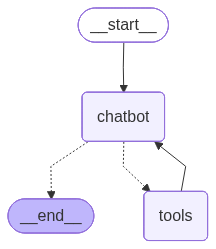

In [17]:
graph

<br>
<br>

### Lets try the "Flow"

In [27]:
user_input = "Explain Docker "

events = graph.stream(
    {"messages" : [("user", user_input)]}, stream_mode = "values"
)

for event in events:
    event["messages"][-1].pretty_print() # This way it will show-up like a beautified chatbot

================================ Human Message =================================

Explain Docker 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (2gdvk5jg2)
 Call ID: 2gdvk5jg2
  Args:
    query: Docker


/Users/soubhiksinha/GitHub/Playing-Around-with-LangGraph/venv/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/soubhiksinha/GitHub/Playing-Around-with-LangGraph/venv/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  wikipedia (jjr8hhe4e)
 Call ID: jjr8hhe4e
  Args:
    query: What is Docker?
================================= Tool Message =================================
Name: wikipedia

Page: Docker (software)
Summary: Docker is a set of platform as a service (PaaS) products that use OS-level virtualization to deliver software in packages called containers. The service has both free and premium tiers. The software that hosts the containers is called Docker Engine. It was first rele
================================== Ai Message ==================================
Tool Calls:
  wikipedia (4wevf1fvm)
 Call ID: 4wevf1fvm
  Args:
    query: Docker Engine
================================= Tool Message =================================
Name: wikipedia

Page: Docker (softwar